In [1]:
url = "https://raw.githubusercontent.com/probml/probml-data/main/data/faithful.txt"


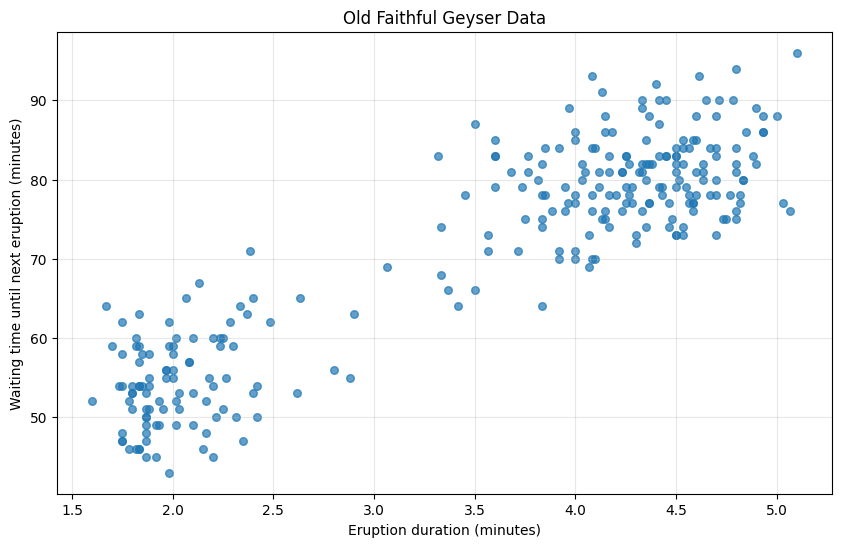

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap

# Create a custom colormap using Set2
set2_colors = sns.color_palette("Set2", 2)
custom_cmap = ListedColormap(set2_colors)

# Read the data
url = "https://raw.githubusercontent.com/probml/probml-data/main/data/faithful.txt"
data = pd.read_csv(url, sep="\s+", names=["eruptions", "waiting"])

# Extract the features
X = data[["eruptions", "waiting"]].values

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.7, s=30)
plt.xlabel("Eruption duration (minutes)")
plt.ylabel("Waiting time until next eruption (minutes)")
plt.title("Old Faithful Geyser Data")
plt.grid(True, alpha=0.3)

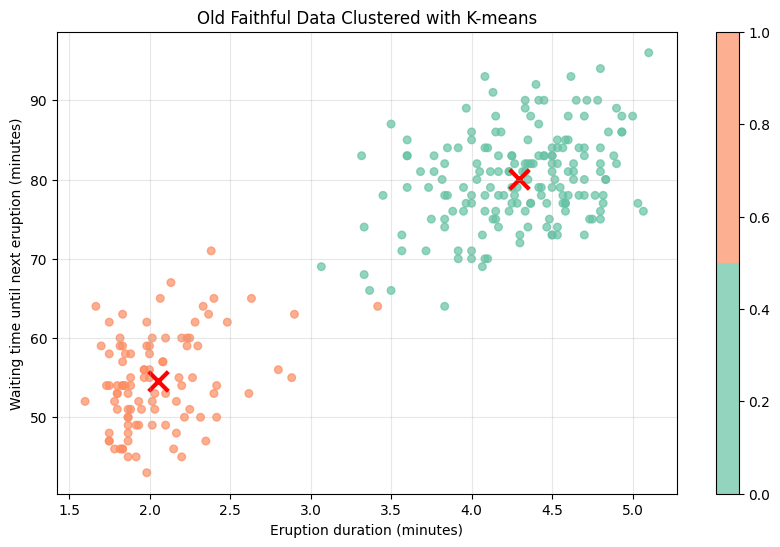

Cluster Centers:
Cluster 1: [ 4.29632759 80.08045977]
Cluster 2: [ 2.05220408 54.59183673]

Inertia: 79.58


In [3]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-means clustering
kmeans = KMeans(n_clusters=2, random_state=40, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Plot the results
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap=custom_cmap, alpha=0.7, s=30)
centers = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=200, linewidths=3)
plt.colorbar(scatter)
plt.xlabel("Eruption duration (minutes)")
plt.ylabel("Waiting time until next eruption (minutes)")
plt.title("Old Faithful Data Clustered with K-means")
plt.grid(True, alpha=0.3)
plt.show()

# Print cluster centers
print("Cluster Centers:")
for i, center in enumerate(centers):
    print(f"Cluster {i+1}: {center}")

# Calculate and print inertia (within-cluster sum of squares)
print(f"\nInertia: {kmeans.inertia_:.2f}")

In [4]:
# Library of Gaussian Mixture Models
# To-do: convert library into class
# Author: Gerardo Durán-Martín

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


def plot_mixtures(X, mu, pi, Sigma, r, step=0.01, cmap="Set2", ax=None):
    ax = ax if ax is not None else plt.subplots()[1]
    colors = ["tab:red", "tab:blue"]
    x0, y0 = X.min(axis=0)
    x1, y1 = X.max(axis=0)
    xx, yy = np.mgrid[x0:x1:step, y0:y1:step]
    zdom = np.c_[xx.ravel(), yy.ravel()]

    Norms = [multivariate_normal(mean=mui, cov=Sigmai) for mui, Sigmai in zip(mu, Sigma)]

    for Norm, color in zip(Norms, colors):
        density = Norm.pdf(zdom).reshape(xx.shape)
        ax.contour(xx, yy, density, levels=1, colors=color, linewidths=5)

    ax.scatter(*X.T, alpha=0.7, c=r, cmap=cmap, s=10)
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)


def compute_responsibilities(k, pi, mu, sigma):
    Ns = [multivariate_normal(mean=mu_i, cov=Sigma_i) for mu_i, Sigma_i in zip(mu, sigma)]

    def respons(x):
        elements = [pi_i * Ni.pdf(x) for pi_i, Ni in zip(pi, Ns)]
        return elements[k] / np.sum(elements, axis=0)

    return respons


def e_step(pi, mu, Sigma):
    responsibilities = []
    for i, _ in enumerate(mu):
        resp_k = compute_responsibilities(i, pi, mu, Sigma)
        responsibilities.append(resp_k)
    return responsibilities


def m_step(X, responsibilities, S=None, eta=None):
    N, M = X.shape
    pi, mu, Sigma = [], [], []
    has_priors = eta is not None
    for resp_k in responsibilities:
        resp_k = resp_k(X)
        Nk = resp_k.sum()
        # mu_k
        mu_k = (resp_k[:, np.newaxis] * X).sum(axis=0) / Nk
        # Sigma_k
        dk = X - mu_k
        Sigma_k = resp_k[:, np.newaxis, np.newaxis] * np.einsum("ij, ik->ikj", dk, dk)
        Sigma_k = Sigma_k.sum(axis=0)
        if not has_priors:
            Sigma_k = Sigma_k / Nk
        else:
            Sigma_k = (S + Sigma_k) / (eta + Nk + M + 2)

        # pi_k
        pi_k = Nk / N

        pi.append(pi_k)
        mu.append(mu_k)
        Sigma.append(Sigma_k)
    return pi, mu, Sigma


def gmm_log_likelihood(X, pi, mu, Sigma):
    likelihood = 0
    for pi_k, mu_k, Sigma_k in zip(pi, mu, Sigma):
        norm_k = multivariate_normal(mean=mu_k, cov=Sigma_k)
        likelihood += pi_k * norm_k.pdf(X)
    return np.log(likelihood).sum()


def apply_em(X, pi, mu, Sigma, threshold=1e-5, S=None, eta=None):
    r = compute_responsibilities(0, pi, mu, Sigma)(X)
    log_likelihood = gmm_log_likelihood(X, pi, mu, Sigma)
    hist_log_likelihood = [log_likelihood]
    hist_coeffs = [(pi, mu, Sigma)]
    hist_responsibilities = [r]

    while True:
        responsibilities = e_step(pi, mu, Sigma)
        pi, mu, Sigma = m_step(X, responsibilities, S, eta)
        log_likelihood = gmm_log_likelihood(X, pi, mu, Sigma)

        hist_coeffs.append((pi, mu, Sigma))
        hist_responsibilities.append(responsibilities[0](X))
        hist_log_likelihood.append(log_likelihood)

        if np.abs(hist_log_likelihood[-1] / hist_log_likelihood[-2] - 1) < threshold:
            break
        results = {"coeffs": hist_coeffs, "rvals": hist_responsibilities, "logl": hist_log_likelihood}
    return results

In [5]:
# Initialize parameters for two Gaussian components
K = 2  # number of components
N, D = X.shape
pi = [1/K] * K  # equal priors
mu = [X[np.random.choice(N, 1)][0] for _ in range(K)]  # random means
Sigma = [np.eye(D) for _ in range(K)]  # identity covariance matrices

# Run EM algorithm
results = apply_em(X, pi, mu, Sigma, threshold=1e-6)

# Extract final parameters
final_pi, final_mu, final_Sigma = results['coeffs'][-1]


<Figure size 1000x600 with 0 Axes>

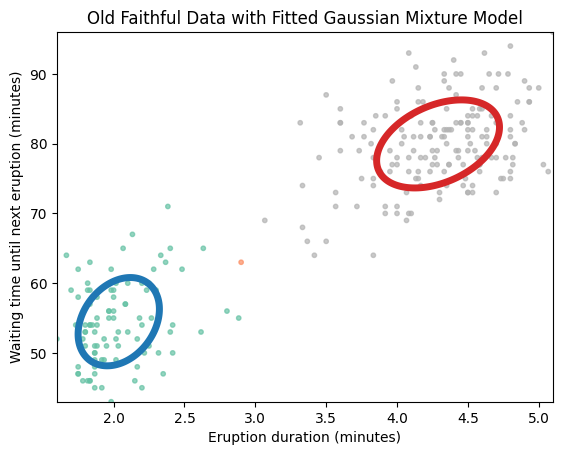

In [6]:

# Plot the result
plt.figure(figsize=(10, 6))
plot_mixtures(X, final_mu, final_pi, final_Sigma, results['rvals'][-1])
plt.xlabel("Eruption duration (minutes)")
plt.ylabel("Waiting time until next eruption (minutes)")
plt.title("Old Faithful Data with Fitted Gaussian Mixture Model")
plt.show()


In [7]:

# Print final parameters
print("Final mixing coefficients (pi):", final_pi)
print("Final means (mu):")
for i, m in enumerate(final_mu):
    print(f"  Component {i+1}: {m}")
print("Final covariance matrices (Sigma):")
for i, s in enumerate(final_Sigma):
    print(f"  Component {i+1}:\n{s}\n")


Final mixing coefficients (pi): [0.6441140644305118, 0.35588593556948817]
Final means (mu):
  Component 1: [ 4.28969013 79.96845562]
  Component 2: [ 2.03642029 54.47883692]
Final covariance matrices (Sigma):
  Component 1:
[[ 0.16993269  0.94015489]
 [ 0.94015489 36.04109775]]

  Component 2:
[[ 0.06919296  0.43543178]
 [ 0.43543178 33.69908749]]



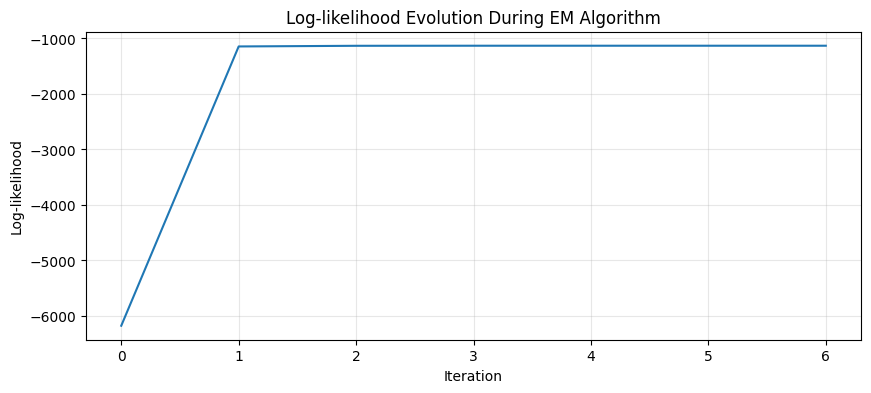

In [8]:

# Plot log-likelihood evolution
plt.figure(figsize=(10, 4))
plt.plot(results['logl'])
plt.xlabel("Iteration")
plt.ylabel("Log-likelihood")
plt.title("Log-likelihood Evolution During EM Algorithm")
plt.grid(True, alpha=0.3)
plt.show()